*Step 1: Import Modules*

In [18]:
# Install Kaggle package if it's not already installed
!pip install kaggle

# Use Kaggle API to download the dataset
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd() # Set the directory where kaggle.json is stored

# Replace 'your-username/your-dataset' with the appropriate dataset path
!kaggle datasets download -d paultimothymooney/breast-histopathology-images -p ./data


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
import zipfile

# Path to the downloaded ZIP file
zip_file_path = './data/breast-histopathology-images.zip'
extract_dir = './data'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed.")

Extraction completed.


In [21]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import imageio
from PIL import Image
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D

# Replacement functions for deprecated scipy.misc functions
def imresize(arr, size):
    return np.array(Image.fromarray(arr).resize(size))

def imread(path):
    return imageio.imread(path)

%matplotlib inline

*Step 2: Explore Data*

In [22]:
# Set the correct local path to the unzipped dataset
imagePatches = glob('./data/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
./data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


In [24]:
import os

def plotImage(image_location):
    # Check if the file exists
    if not os.path.exists(image_location):
        print(f"Error: The file {image_location} does not exist.")
        return
    
    image = cv2.imread(image_location)
    
    # Check if the image was loaded correctly
    if image is None:
        print(f"Error: Unable to load image from {image_location}.")
        return
    
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


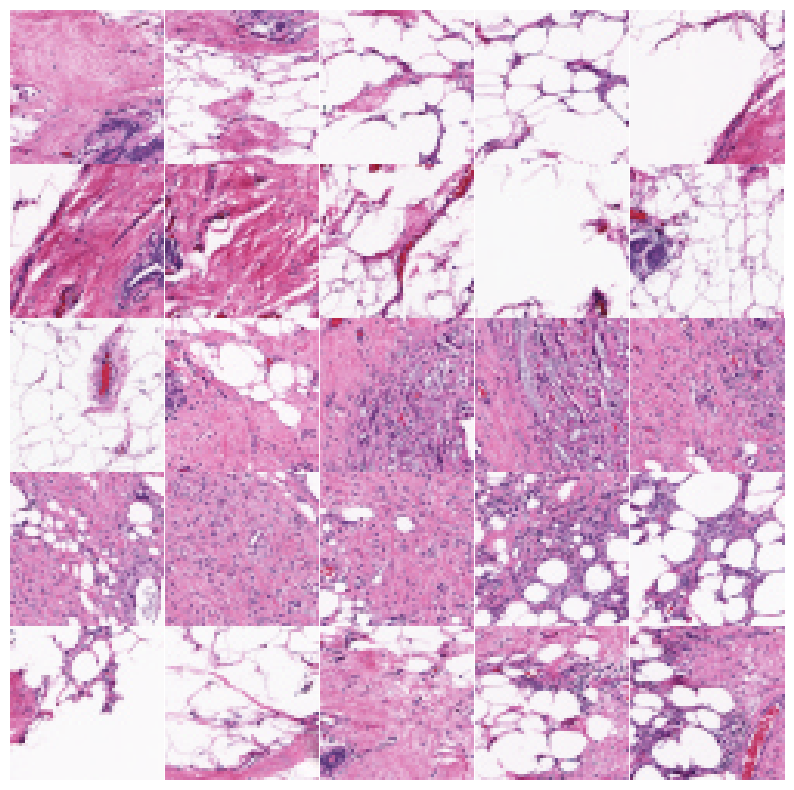

In [25]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

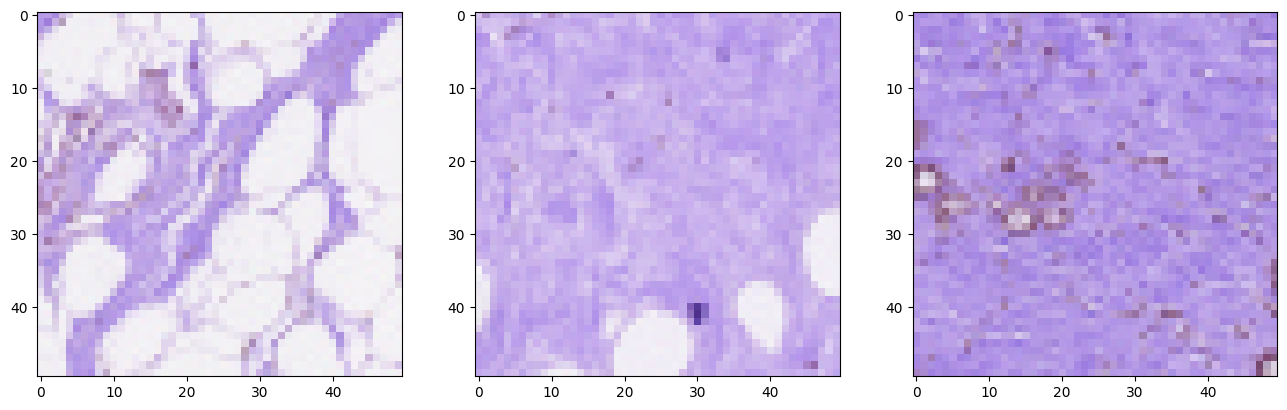

In [30]:
def randomImages(a):
    r = random.sample(a, 4)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
randomImages(imagePatches)

*Step 3: Preprocess Data*

In [31]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['./data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['./data/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png', './data/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png', './data/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', './data/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png', './data/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y401_class1.png']


In [32]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [33]:
X,Y = proc_images(0,90000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [34]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 90000
Number of IDC(-) Images: 64583
Number of IDC(+) Images: 25417
Percentage of positive images: 28.24%
Image shape (Width, Height, Channels): (50, 50, 3)


In [35]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[206, 164, 226], [196, 154, 224], [211, 175,...       0
1  [[[197, 150, 219], [201, 158, 217], [205, 173,...       0
2  [[[249, 245, 248], [248, 246, 248], [253, 246,...       0
3  [[[249, 247, 249], [249, 247, 249], [249, 247,...       0
4  [[[237, 231, 241], [245, 242, 246], [235, 222,...       0
5  [[[248, 246, 248], [248, 246, 248], [248, 246,...       0
6  [[[175, 120, 212], [145, 88, 175], [132, 72, 1...       0
7  [[[87, 38, 142], [120, 94, 165], [195, 180, 21...       0
8  [[[235, 228, 240], [242, 240, 246], [252, 244,...       0
9  [[[238, 223, 242], [239, 235, 241], [250, 245,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


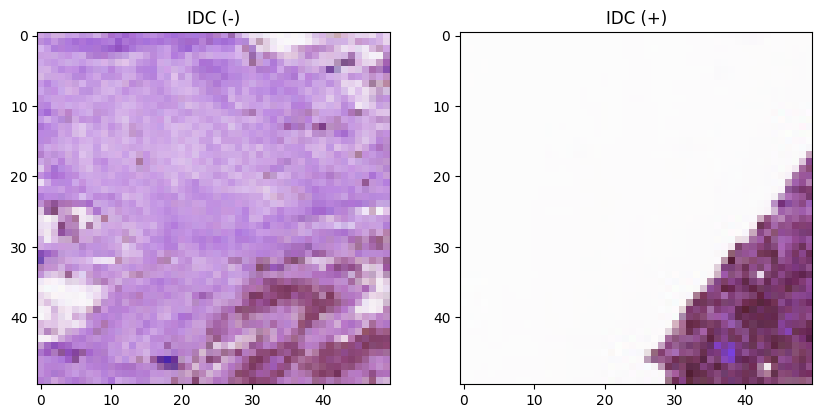

In [36]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[0])
plotOne(imgs0, imgs1) 

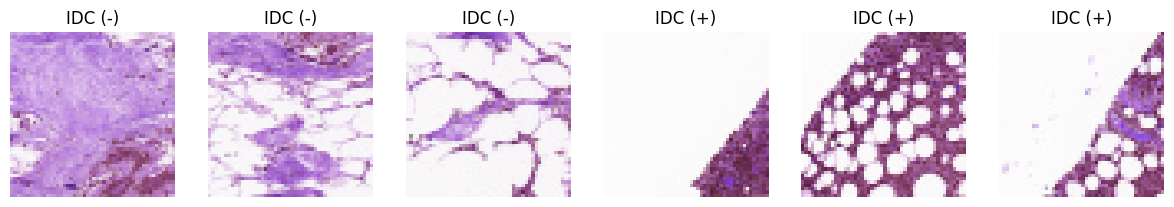

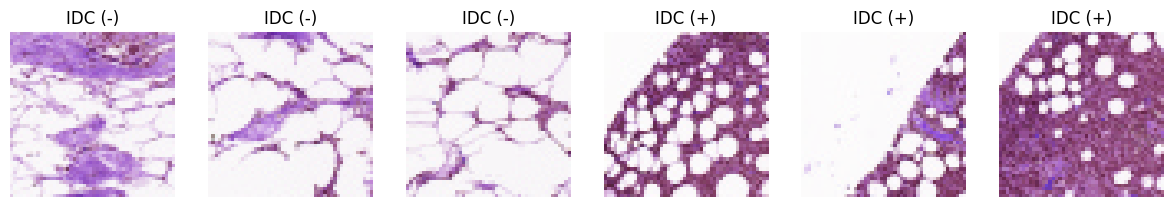

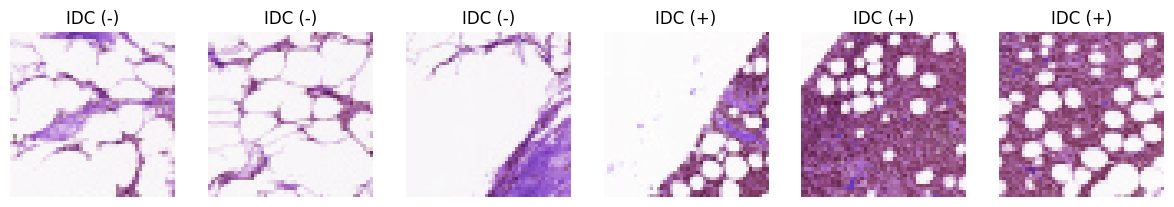

In [37]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

The data is scaled from 0 to 256 but we want it to be scaled from 0 to 1. This will make the data compatible with a wide variety of different classification algorithms.  We also want to set aside 20% of the data for testing. This will make the trained model less prone to overfitting.  And finally, we will use an oversampling strategy to deal with the imbalanced class sizes.

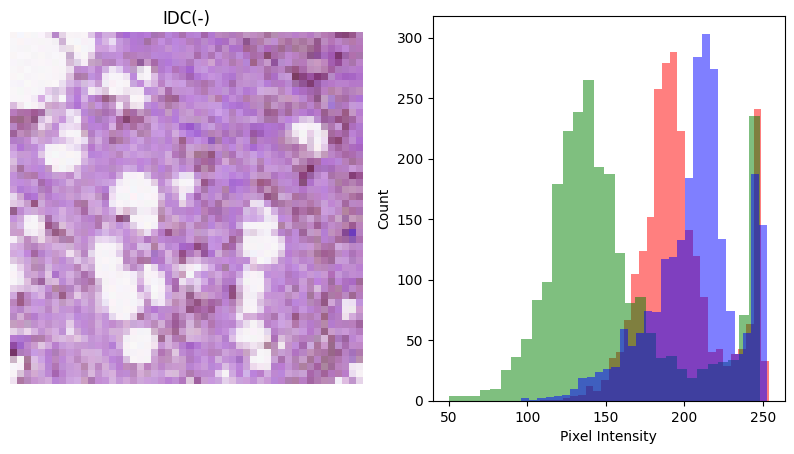

In [38]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

In [39]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 
Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (72000, 50, 50, 3)
Testing Data Shape: (18000, 50, 50, 3)


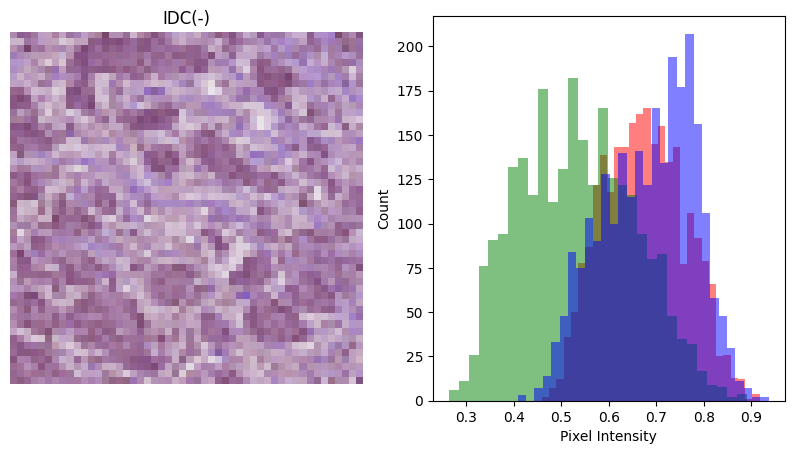

In [40]:
plotHistogram(X_train[100])

In [41]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

{0: 'IDC(-)', 1: 'IDC(+)'}


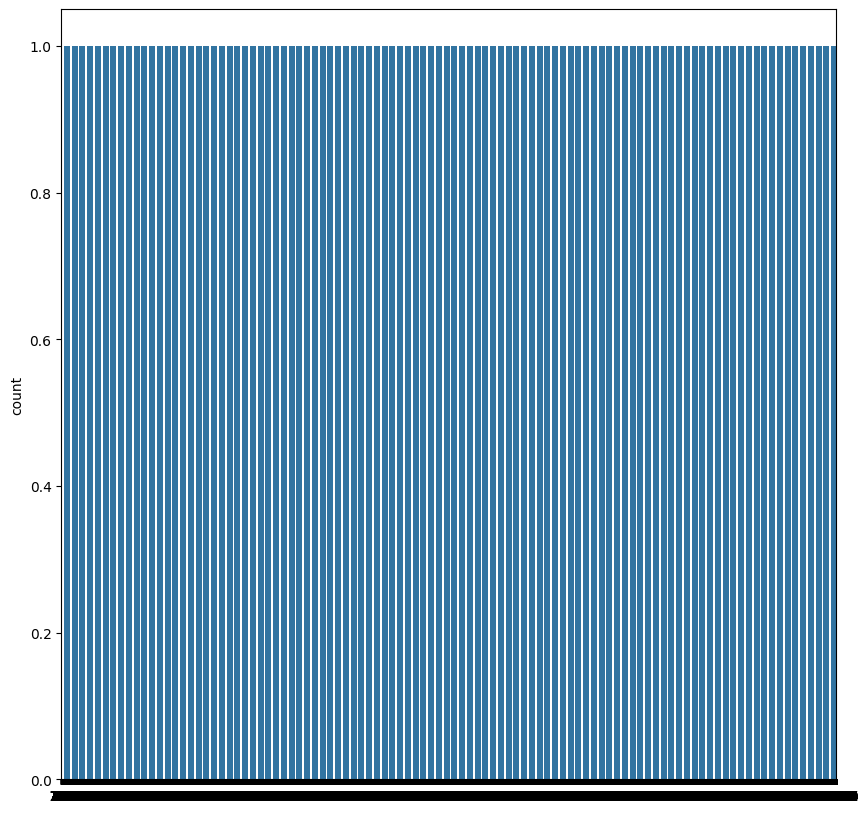

In [42]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

{0: 'IDC(-)', 1: 'IDC(+)'}


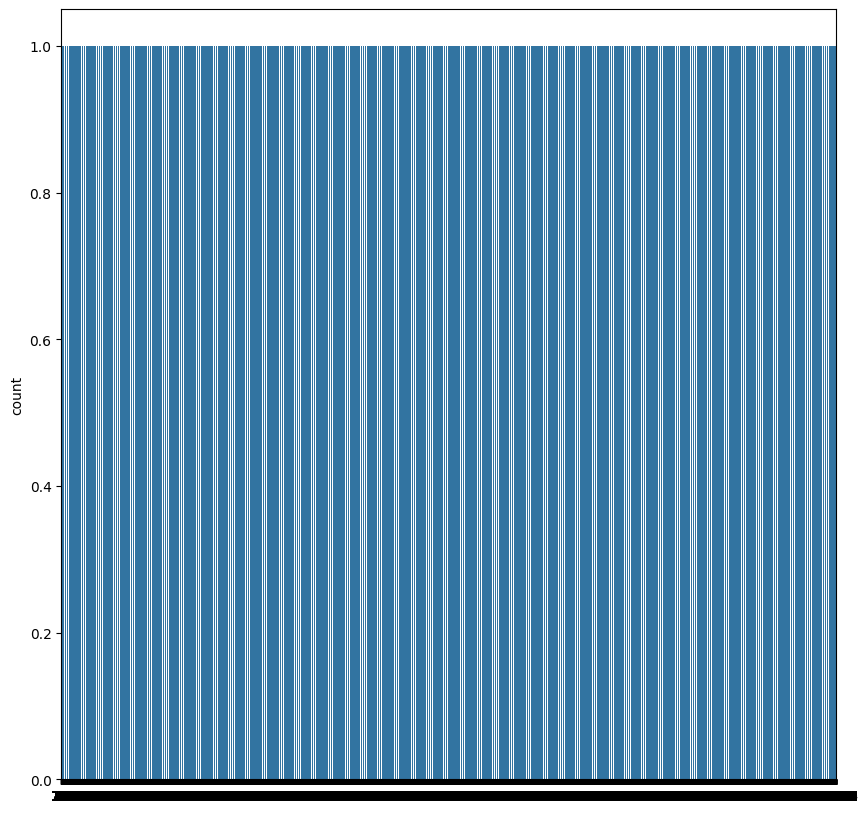

In [45]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(sampling_strategy='auto')
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

*Step 4: Define Helper Functions for the Classification Task*

In [48]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)

print("Old Class Weights: ", class_weights)

class_weight2 = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_trainRos),
    y=Y_trainRos
)

print("New Class Weights: ", class_weight2)

Old Class Weights:  [0.69675621 1.77060791]
New Class Weights:  [1. 1.]


In [61]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True).item()  # Add allow_pickle=True
    filt = ['acc']  # Try to add 'loss' to see the loss learning curve
    for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
        plt.plot(metrics[k], label=k)
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [65]:
class MyDataset(tf.data.Dataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)  # Add this line
        # Custom initialization


*Step 5: Evaluate Classification Models*

C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/12
   6/1270 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.4602 - loss: 0.7212   

C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1270/1270 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5031 - loss: 0.7010 - val_accuracy: 0.5413 - val_loss: 0.6765
Epoch 2/12
   1/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5312 - loss: 0.6859

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - accuracy: 0.5312 - loss: 0.3432 - val_accuracy: 0.5439 - val_loss: 0.6765
Epoch 3/12
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5666 - loss: 0.6791 - val_accuracy: 0.6639 - val_loss: 0.6540
Epoch 4/12
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.6250 - loss: 0.3355 - val_accuracy: 0.6647 - val_loss: 0.6539
Epoch 5/12
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6256 - loss: 0.6603 - val_accuracy: 0.7041 - val_loss: 0.6291
Epoch 6/12
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.6562 - loss: 0.3205 - val_accuracy: 0.7059 - val_loss: 0.6291
Epoch 7/12
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6542 - loss: 0.6392 - val_accuracy: 0.7064 - val_loss: 0.6065
Epoch 8/12
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.6562 - loss: 0.3209 - val_accuracy: 0.7055 - val_loss: 0.6065
Epoch 9/12
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6799 - loss: 0.61

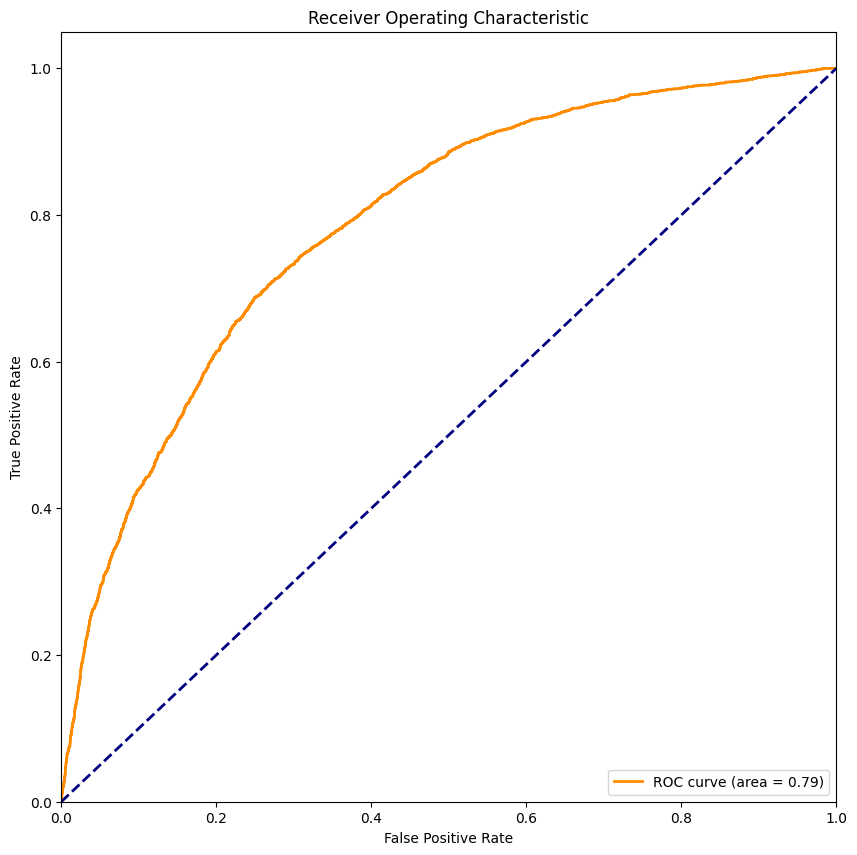


              precision    recall  f1-score   support

      IDC(-)       0.73      0.69      0.71      5085
      IDC(+)       0.71      0.74      0.72      5085

    accuracy                           0.72     10170
   macro avg       0.72      0.72      0.72     10170
weighted avg       0.72      0.72      0.72     10170



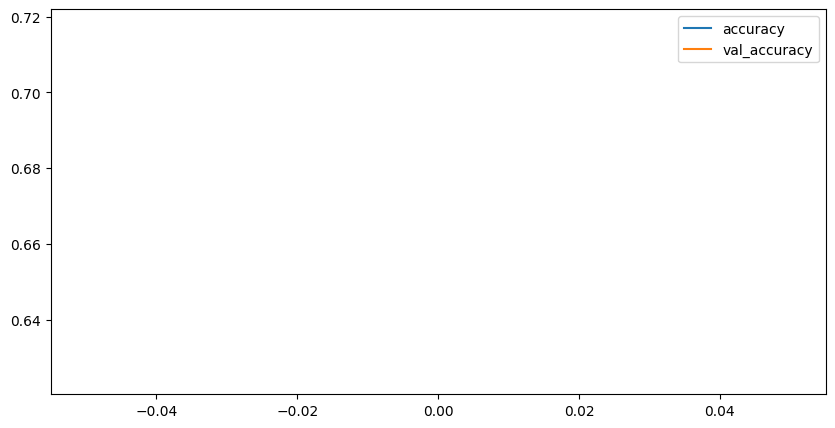

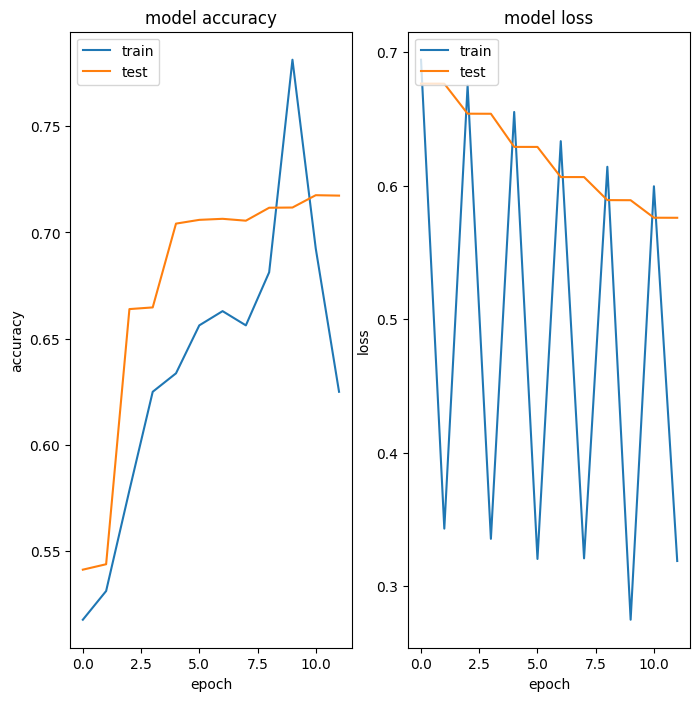

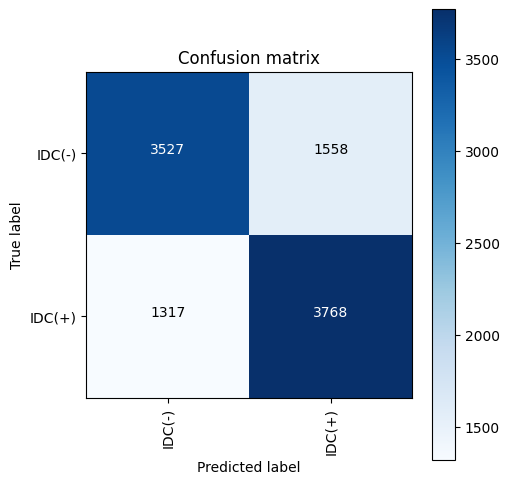

In [88]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def runKerasCNNAugment(X_train, Y_train, X_test, Y_test, stride, epochs=12):
    """
    Run Keras CNN with data augmentation and generate ROC curve.
    """
    batch_size = 32  # Ensure batch_size is an integer
    num_classes = 2
    
    # Ensure Y_train is in the correct format (e.g., one-hot encoded)
    if Y_train.ndim > 1 and Y_train.shape[1] > 1:
        Y_train_labels = np.argmax(Y_train, axis=1)
    else:
        Y_train_labels = Y_train
    
    # Compute class weights
    class_weight_raw = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(Y_train_labels),
        y=Y_train_labels
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weight_raw)}
    
    img_rows, img_cols = 50, 50
    input_shape = (img_rows, img_cols, 3)
    
    # Define the model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, strides=int(stride)))  # Ensure stride is an integer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adadelta',
                  metrics=['accuracy'])
    
    # Data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    # Calculate steps_per_epoch carefully
    steps_per_epoch = len(X_train) // batch_size

    # Check if steps_per_epoch is valid
    if steps_per_epoch < 1:
        steps_per_epoch = 1

    # Train the model
    history = model.fit(
        datagen.flow(X_train, Y_train, batch_size=batch_size),
        steps_per_epoch=steps_per_epoch,  # Ensure this matches your data size
        epochs=int(epochs),  # Ensure epochs is an integer
        class_weight=class_weight_dict,
        validation_data=(X_test, Y_test),
        callbacks=[MetricsCheckpoint('logs')]
    )

    # Evaluate the model
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_prob = y_pred[:, 1]  # Probability of the positive class
    
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(np.argmax(Y_test, axis=1), y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    # Classification report
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', classification_report(np.where(Y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    
    # Plotting
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(Y_test, axis=1)
    
    plotKerasLearningCurve()
    plt.show()
    
    plot_learning_curve(history)
    plt.show()
    
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plot_confusion_matrix(confusion_mtx, classes=list(map_characters.values()))
    plt.show()

runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, stride=2)

Next I will try one more time but without the undersampling step.

C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/8
   6/2250 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.4719 - loss: 0.7153   

C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6831 - loss: 0.6047 - val_accuracy: 0.7175 - val_loss: 0.5681
Epoch 2/8


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7175 - val_loss: 0.5681
Epoch 3/8
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.7203 - loss: 0.5702 - val_accuracy: 0.7175 - val_loss: 0.5632
Epoch 4/8
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7175 - val_loss: 0.5632
Epoch 5/8
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.7189 - loss: 0.5660 - val_accuracy: 0.7175 - val_loss: 0.5575
Epoch 6/8
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7175 - val_loss: 0.5575
Epoch 7/8
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7157 - loss: 0.5610 - val_accuracy: 0.7175 - val_loss: 0.5508
Epoch 8/8
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7175 - val_loss: 0.5508

Keras CNN #1C - accuracy: 0.7174999713897705 

563/563 ━━━━━

C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

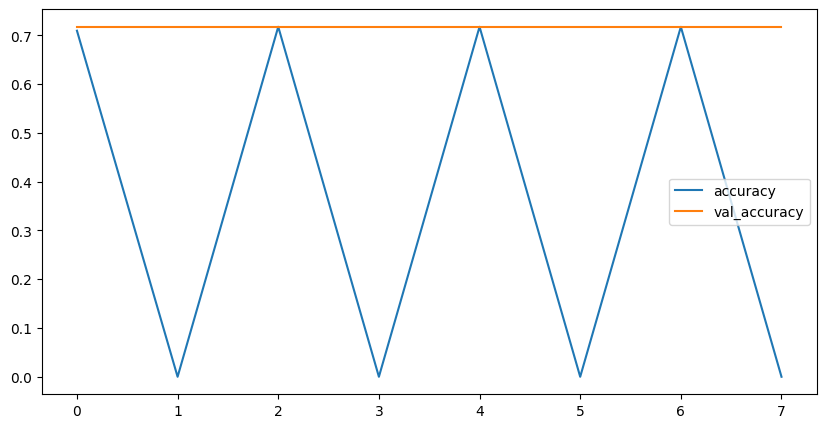

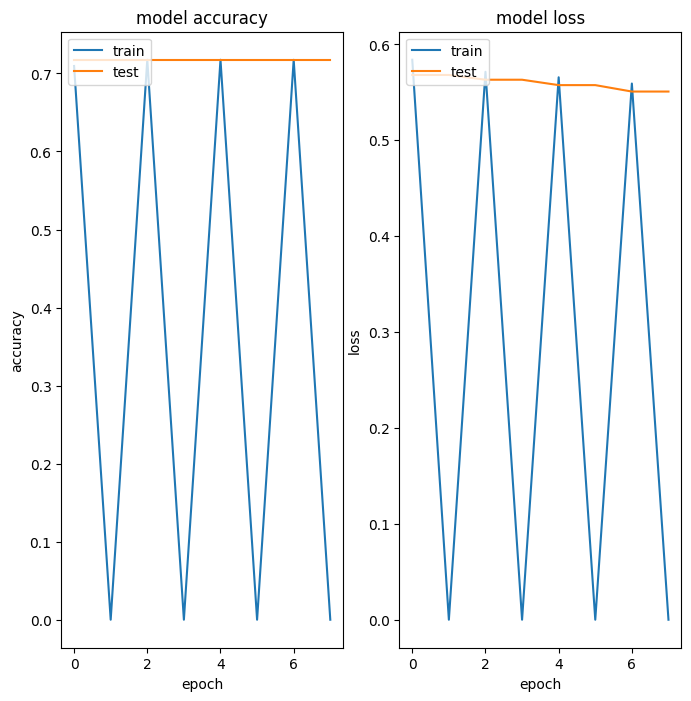

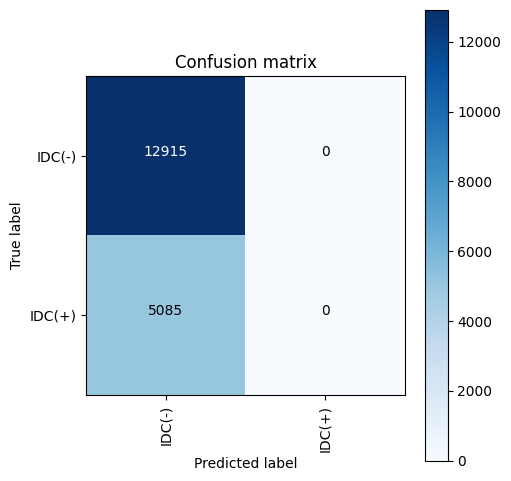

In [60]:
runKerasCNNAugment(X_train, Y_trainHot, X_test, Y_testHot,2,class_weight)

90+% accuracy is pretty good!  And it does not look too be to overfit or too biased based off of the learning curve and confusion matrix.  In the future, I will improve the score by optimizing the data augmentation step as well as the network architecture.